<a href="https://colab.research.google.com/github/3778/COVID-19/blob/master/notebooks/%5BIssue_30%5D_Simulador_Leitos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install simpy

In [0]:
from collections import defaultdict
import numpy as np
import pandas as pd
import simpy

In [0]:
def gen_time_between_arrival():
    return np.random.random() / 2

def gen_days_in_ward():
    return np.random.randint(15, 20)

def gen_days_in_icu():
    return np.random.randint(15, 45)

def gen_go_to_icu():
    return np.random.random() < 0.10

def gen_recovery():
    return np.random.random() < 0.90

def gen_priority():
    return np.random.randint(1, 5)

def gen_icu_max_wait():
    return np.random.randint(2, 5)

def gen_ward_max_wait():
    return np.random.randint(5, 15)

In [0]:
def request_icu(env, icu):
    logger['requested_icu'].append(env.now)
    priority = gen_priority()
    with icu.request(priority=priority) as icu_request:
        time_of_arrival = env.now
        final = yield icu_request | env.timeout(gen_icu_max_wait())
        logger['time_waited_icu'].append(env.now - time_of_arrival)
        logger['priority_icu'].append(priority)
        if icu_request in final:
            yield env.timeout(gen_days_in_icu())
        else:
            logger['lost_patients_icu'].append(env.now)

In [0]:
def request_ward(env, ward):
    logger['requested_ward'].append(env.now)
    with ward.request() as ward_request:
        time_of_arrival = env.now
        final = yield ward_request | env.timeout(gen_ward_max_wait())
        if ward_request in final:
            logger['time_waited_ward'].append(env.now - time_of_arrival)
            yield env.timeout(gen_days_in_ward())
        else:
            logger['lost_patients_ward'].append(env.now)

In [0]:
def patient(env, ward, icu):
    if gen_go_to_icu():
        yield env.process(request_icu(env, icu))
        if not gen_recovery():
            logger['deaths'].append(env.now)
        else:
            yield env.process(request_ward(env, ward))
    else:
        yield env.process(request_ward(env, ward))
        if not gen_go_to_icu():
            logger['recovered_from_ward'].append(env.now)
        else:
            yield env.process(request_icu(env, icu))
            if not gen_recovery():
                logger['deaths'].append(env.now)
            else:
                yield env.process(request_ward(env, ward))
                

In [0]:
def generate_patients(env, ward, icu):
    while True:
        env.process(patient(env, ward, icu))
        yield env.timeout(gen_time_between_arrival())

In [0]:
def observer(env, ward, icu):
    while True:
        logger['queue_ward'].append(len(ward.queue))
        logger['queue_icu'].append(len(icu.queue))
        logger['count_ward'].append(ward.count)
        logger['count_icu'].append(icu.count)
        yield env.timeout(1)

In [0]:
nsim = 120
logger = defaultdict(list)
env = simpy.Environment()
ward = simpy.Resource(env, 75)
icu = simpy.PriorityResource(env, 15)
env.process(generate_patients(env, ward, icu))
env.process(observer(env, ward, icu))
env.run(until=nsim)

In [10]:
pd.Series(logger['time_waited_ward']).describe()

count    489.000000
mean       1.484098
std        1.230753
min        0.000000
25%        0.000000
50%        1.828816
75%        2.403301
max        3.789008
dtype: float64

In [11]:
len(logger['deaths'])

5

In [12]:
len(logger['lost_patients_ward'])

0

In [13]:
len(logger['lost_patients_icu'])

32

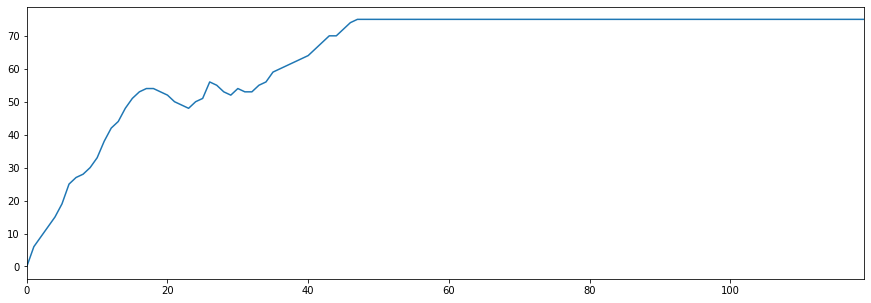

In [14]:
pd.Series(logger['count_ward']).plot(figsize=(15, 5));

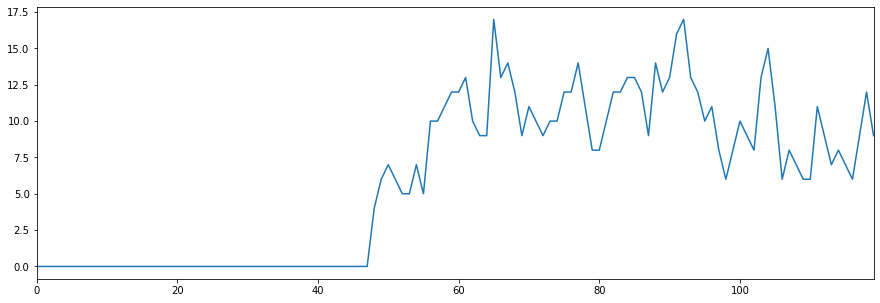

In [15]:
pd.Series(logger['queue_ward']).plot(figsize=(15, 5));

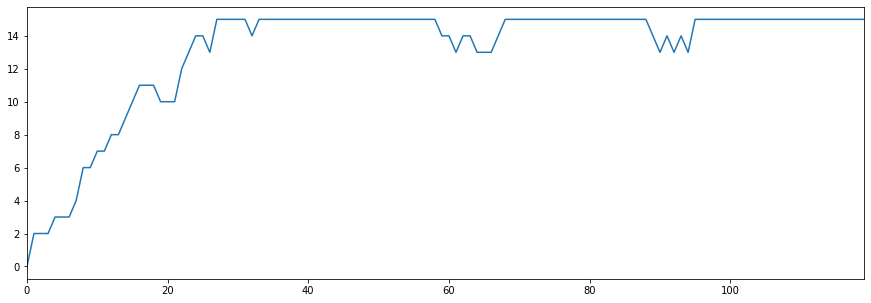

In [16]:
pd.Series(logger['count_icu']).plot(figsize=(15, 5));

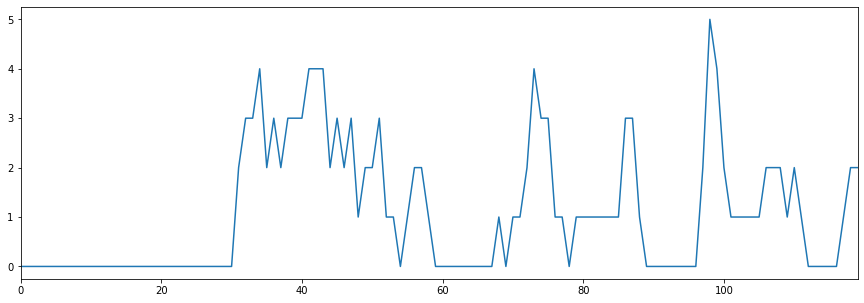

In [17]:
pd.Series(logger['queue_icu']).plot(figsize=(15, 5));

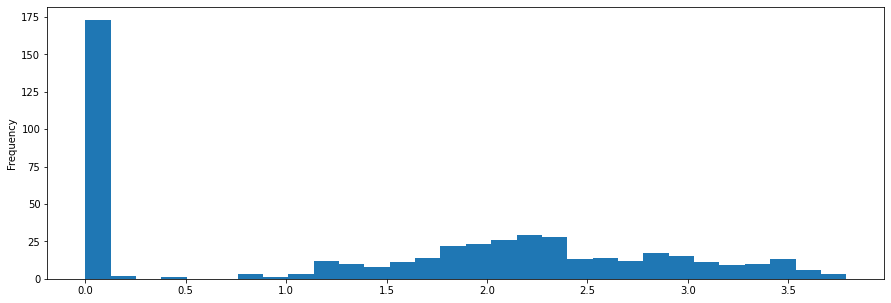

In [18]:
pd.Series(logger['time_waited_ward']).plot.hist(bins=30, figsize=(15, 5));

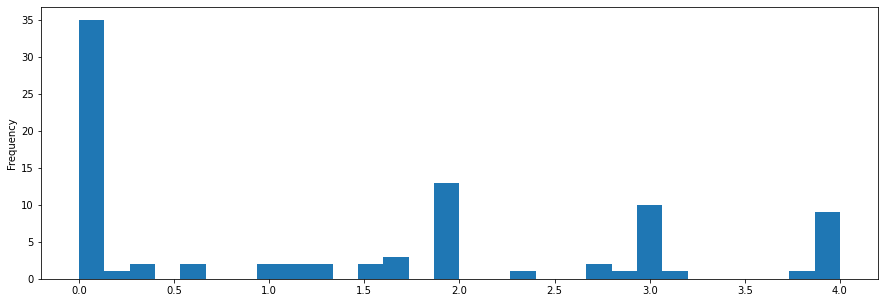

In [19]:
pd.Series(logger['time_waited_icu']).plot.hist(bins=30, figsize=(15, 5));

In [20]:
(
    pd.DataFrame(
        np.column_stack(
            [logger['priority_icu'], logger['time_waited_icu']]
        ),
        columns=['priority_icu', 'time_waited_icu']
    )
    .groupby('priority_icu')
    ['time_waited_icu']
    .mean()
    .rename('mean_time_waited_by_priority_level')
    .to_frame()
)

,mean_time_waited_by_priority_level
priority_icu,
1.0,1.167728
2.0,1.010369
3.0,1.796703
4.0,1.683219
